# Nice Weather
### by Kenny Taliaferro

### Summary
This project is designed to help travelers find a destination with nice weather.

### User Input

* A month
* A desired temperature range (minimum desired low and maximum desired high)
* A desired longitude and latitude range (optional, default is the entire globe)

### Program Output
A map with shaded regions that indicate how nice the weather is.

* The green region is in the desired temperature range
* The yellow region is within 10 degrees of the desired temperature range
* The red region is not within 10 degrees of the desired temperature range

![world](./world.png)

![US](./us.png)

### Data
The data consists of daily weather readings that were taken from roughly 10,000 weather stations around the world in 2014.  We take a random sample of 1,000 of these stations and use lenear interpolation to determine the weather at all points on the globe.  <a href="ftp://ftp.ncdc.noaa.gov/pub/data/gsod">ftp://ftp.ncdc.noaa.gov/pub/data/gsod</a>

In [1]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import random
from scipy.interpolate import griddata
import time

from data_directory import data_directory

times = []
tasks = []
times.append(time.time())
tasks.append('start')

In [2]:
# Skip the plotting step if desired.
skip_plot = False

# Choose a month to average over.
# January is month 0, February is month 1, etc.
month = 6

# Choose the number of stations to use.
# More stations results in more precise interpolation, but
# longer compute times.  There are roughly 10,000 stations
# with enough data for analysis.
max_stations = 1000

# Choose a longitude and latitude range of interest.  The first half of
# the stations will be chosen randomly from the globe.  The second half of
# the stations will be chosen randomly from the region of interest.
lon_interest = [-120, -60]
lat_interest = [15, 55]

# Choose a desired temperature range
max_desired_high = 80
min_desired_low = 50

month_names = ['January', 'February', 'March', 'April', 'May',
              'June', 'July', 'August', 'September', 'October',
              'November', 'December']

print 'max stations:', max_stations
print 'month:', month_names[month]
print 'desired temperature range:', [min_desired_low, max_desired_high]
print 'longitude range of interest:', lon_interest
print 'latitude range of interest:', lat_interest
print ''
color_description = \
    'Highs and lows in the green regions are within the\n' + \
    'desired temperature range of {0}-{1} '.format(min_desired_low, max_desired_high) + 'degrees Fahrenheit.\n\n' + \
    'Highs and lows in the yellow regions are\nwithin 10 degrees of the desired temperature range.\n\n' + \
    'Highs and lows the red regions are not\nwithin 10 degrees of the desired temperature range.\n'
    
# cd to the data directory.
os.chdir(data_directory)

max stations: 1000
month: July
desired temperature range: [50, 80]
longitude range of interest: [-120, -60]
latitude range of interest: [15, 55]



In [3]:
# Store each station ID along with the station's latitude and longitude.

stations = []
countries = []
latitudes = []
longitudes = []

with open('../isd-history.txt', 'rU') as f:
    # Skip the 'readme' portion of the text file.
    for i in range(21):
        next(f)
    for line in f:
        stations.append(line[:6])
        latitudes.append(line[51:58])
        longitudes.append(line[59:67])
        
df = pd.DataFrame({
                'Latitude': latitudes,
                'Longitude': longitudes,
                'Station': stations})
df = df.set_index('Station')

# Remove stations with missing data.
df = df[df.Longitude != '        ']
df = df[df.Longitude != '+000.000']
df = df[df.Latitude != '       ']
df = df[df.Latitude != '+00.000']

# Convert longitude and latitude to floating point values.
df[['Longitude', 'Latitude']] = df[['Longitude', 'Latitude']].astype(float)

# Remove rows with bad longitude and latitude values.
df = df[df.Longitude > -179]
df = df[df.Longitude < 179]
df = df[df.Latitude > -89]
df = df[df.Latitude < 89]

print len(df), 'rows before dropping duplicates'

# These three lines drop duplicate indices.
grouped = df.groupby(level=0)
df = grouped.last()
df

times.append(time.time())
tasks.append('process station data')

df_stations = df
print len(df_stations), 'rows after dropping duplicates\n'
df_stations.head()

77816 rows before dropping duplicates
74357 rows after dropping duplicates



,Latitude,Longitude
Station,,
008268,32.950,65.567
008270,31.983,65.483
008284,32.950,66.633
010010,70.933,-8.667
010014,59.792,5.341


In [4]:
# Store the temperature data.

n_files_kept = 0
n_files_dropped = 0
df_temps = pd.DataFrame({'Month':[], 'Station':[], 'Mean':[], 'Low':[], 'High':[]})
file_list = os.listdir('.')
random.shuffle(file_list)
for fn in file_list:
    if n_files_kept >= max_stations:
        break
    if (os.path.isfile(fn)) and (fn[-2:] == 'gz') and (fn[:6] in df_stations.index):
        if (n_files_kept >= max_stations // 2) and \
               ((df_stations.loc[fn[:6]].Longitude < lon_interest[0]) or \
                (df_stations.loc[fn[:6]].Longitude > lon_interest[1]) or \
                (df_stations.loc[fn[:6]].Latitude < lat_interest[0]) or \
                (df_stations.loc[fn[:6]].Latitude > lat_interest[1])):
            continue
        with gzip.open(fn, 'rb') as f:
            f.next() # skip the first line, which has the column headings
            stations = []
            months = []
            days = []
            temps = []
            lows = []
            highs = []
            for line in f:
                stations.append(line[0:6])
                months.append(line[18:20])
                days.append(line[20:22])
                temps.append(line[24:30])
                lows.append(line[110:116])
                highs.append(line[103:108])

        df = pd.DataFrame({
                            'Month': months,
                            'Station': stations,
                            'Day': days,
                            'Mean': temps,
                            'Low': lows,
                            'High': highs})
        
        # Remove rows with missing data.
        df = df[df.Mean != '9999.9']
        df = df[df.Low != '9999.9']
        df = df[df.High != '9999.9']
        
        # Fix datatypes.
        df[['Mean', 'Low', 'High']] = df[['Mean', 'Low', 'High']].astype(float)
        df[['Month', 'Day']] = df[['Month', 'Day']].astype(int)
        
        # Average over the months and remove stations with no entries for
        # some month.
        df = df.drop('Day', axis = 1)
        df_grouped = df.groupby(['Station','Month'])
        if len(df_grouped) < 12:
            n_files_dropped += 1
            continue
        df = df_grouped.aggregate(np.mean).reset_index()

        df_temps = pd.concat((df_temps, df), ignore_index = True)
        n_files_kept += 1
        

# Fix the order of the columns.
df_temps = df_temps[['Station','Month','Mean','Low','High']]

times.append(time.time())
tasks.append('process weather data')

print n_files_kept + n_files_dropped, 'files processed'
print n_files_kept, 'files had sufficient data'
print n_files_dropped, 'files had insufficent data'

1142 files processed
1000 files had sufficient data
142 files had insufficent data


In [5]:
# Compute temperature scores.

# low score = low - min_desired_low
# high score = max_desired_high - high
# temperature score = min(low score, high score)

# A positive score indicates that the high and low fall into the desired range.
# A negative score indicates that one or both of the high and low are out of the desired range.

df_temps['Low Score'] = df_temps['Low'] - min_desired_low
df_temps['High Score'] = max_desired_high - df_temps['High']
df_temps['Temperature Score'] = df_temps.loc[:,['High Score', 'Low Score']].min(axis = 1)

In [6]:
# Display the temperature data.

print len(df_temps), 'rows\n'
df_temps.head()

12000 rows



,Station,Month,Mean,Low,High,Low Score,High Score,Temperature Score
0,066850,1,36.390323,31.009677,42.522581,-18.990323,37.477419,-18.990323
1,066850,2,38.910714,32.435714,47.096429,-17.564286,32.903571,-17.564286
2,066850,3,43.909677,35.322581,54.135484,-14.677419,25.864516,-14.677419
3,066850,4,51.476667,43.256667,60.810000,-6.743333,19.190000,-6.743333
4,066850,5,54.441935,46.119355,63.164516,-3.880645,16.835484,-3.880645


In [7]:
df_temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
Station              12000 non-null object
Month                12000 non-null float64
Mean                 12000 non-null float64
Low                  12000 non-null float64
High                 12000 non-null float64
Low Score            12000 non-null float64
High Score           12000 non-null float64
Temperature Score    12000 non-null float64
dtypes: float64(7), object(1)
memory usage: 843.8+ KB


In [8]:
# Discard data for the 11 irrelevant months and
# join the dataframes in preparation for plotting

# Note the "(month + 1)" below.  Our dataset begins indexing with 1,
# but we will begin indexing with 0.
month_data = df_stations.join(df_temps[df_temps.Month == (month + 1)].set_index('Station'), how = 'inner')
print len(month_data), 'total rows'

month_data_interest = month_data[month_data.Longitude > lon_interest[0]]
month_data_interest = month_data_interest[month_data_interest.Longitude < lon_interest[1]]
month_data_interest = month_data_interest[month_data_interest.Latitude > lat_interest[0]]
month_data_interest = month_data_interest[month_data_interest.Latitude < lat_interest[1]]
print len(month_data_interest), 'rows in the region of interest\n'


times.append(time.time())
tasks.append('join dataframes')

month_data.head()

1000 total rows
636 rows in the region of interest



,Latitude,Longitude,Month,Mean,Low,High,Low Score,High Score,Temperature Score
Station,,,,,,,,,
010250,69.683,18.919,7,58.051613,51.325806,65.319355,1.325806,14.680645,1.325806
010875,59.567,2.217,7,59.335484,56.332258,63.016129,6.332258,16.983871,6.332258
011070,67.517,12.100,7,56.200000,52.196774,60.777419,2.196774,19.222581,2.196774
011620,68.583,15.017,7,60.800000,52.319355,68.370968,2.319355,11.629032,2.319355
011830,68.491,16.678,7,64.248387,53.948387,73.387097,3.948387,6.612903,3.948387


In [9]:
print month_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 010250 to 999999
Data columns (total 9 columns):
Latitude             1000 non-null float64
Longitude            1000 non-null float64
Month                1000 non-null float64
Mean                 1000 non-null float64
Low                  1000 non-null float64
High                 1000 non-null float64
Low Score            1000 non-null float64
High Score           1000 non-null float64
Temperature Score    1000 non-null float64
dtypes: float64(9)
memory usage: 78.1+ KB
None


/home/commodore/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


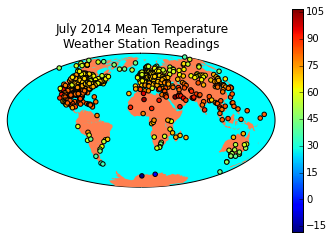

In [10]:
# Plot the mean temperature readings on the globe

if not skip_plot:
    %matplotlib inline

    m = Basemap(projection='hammer',
                  lat_0=0, lon_0=0)
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    #map.drawcoastlines(linewidth=0.25)

    lons = month_data['Longitude'].values.tolist()
    lats = month_data['Latitude'].values.tolist()
    colors = month_data['Mean'].values.tolist()

    m.scatter(*m(lons, lats), marker='o', c=colors, zorder=10)
    plt.colorbar()
    plt.title(month_names[month] +' 2014 Mean Temperature\n'
              + 'Weather Station Readings')
    plt.show()

/home/commodore/anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


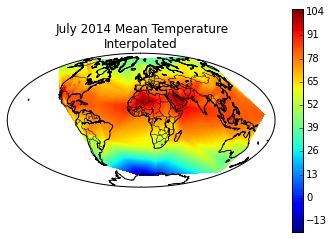

In [11]:
# Interpolate the mean temperature readings on the globe

if not skip_plot:
    m = Basemap(projection='hammer', 
                  lat_0=0, lon_0=0)
    #m.drawmapboundary(fill_color='aqua')
    #m.fillcontinents(color='coral',lake_color='aqua')

    m.drawcoastlines()
    #m.drawstates()
    m.drawcountries()

    lons = np.array(month_data['Longitude'].values.tolist())
    lats = np.array(month_data['Latitude'].values.tolist())
    values = np.array(month_data['Mean'].values.tolist())
    lons, lats = m(lons, lats)

    # We use integers so that the colorbar labels are integers,
    # which looks nice.
    lower_bound = int(np.floor(values.min()))
    upper_bound = int(np.ceil(values.max()))

    m.contourf(lons, lats, values, tri=True,
               levels = np.arange(lower_bound, upper_bound, 1))
    plt.title(month_names[month] +' 2014 Mean Temperature\n'
              + 'Interpolated')
    plt.colorbar()
    plt.show()

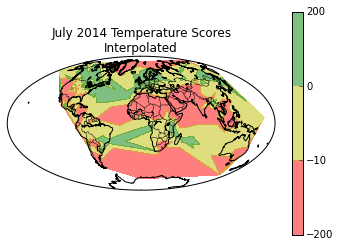

Highs and lows in the green regions are within the
desired temperature range of 50-80 degrees Fahrenheit.

Highs and lows in the yellow regions are
within 10 degrees of the desired temperature range.

Highs and lows the red regions are not
within 10 degrees of the desired temperature range.



In [12]:
# Interpolate the temperature scores on the globe

if not skip_plot:
    m = Basemap(projection='hammer', 
                  lat_0=0, lon_0=0)
    #m.drawmapboundary(fill_color='aqua')
    #m.fillcontinents(color='coral',lake_color='aqua')

    m.drawcoastlines()
    #m.drawstates()
    m.drawcountries()

    lons = np.array(month_data['Longitude'].values.tolist())
    lats = np.array(month_data['Latitude'].values.tolist())
    values = np.array(month_data['Temperature Score'].values.tolist())
    lons, lats = m(lons, lats)

    # We use integers so that the colorbar labels are integers,
    # which looks nice.
    lower_bound = int(np.floor(values.min()))
    upper_bound = int(np.ceil(values.max()))

    m.contourf(lons, lats, values, tri=True,
               #levels = np.arange(lower_bound, upper_bound, 1))
               levels = [-200,-10,0,200], colors=('r','y','g'), alpha = .5)
    plt.title(month_names[month] +' 2014 Temperature Scores\n'
              + 'Interpolated')
    plt.colorbar()
    plt.show()
    print color_description

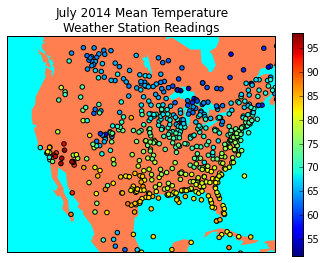

In [13]:
# Plot the mean temperature readings in the region of interest

if not skip_plot:
    m = Basemap(llcrnrlon = lon_interest[0], llcrnrlat = lat_interest[0],
                urcrnrlon = lon_interest[1], urcrnrlat = lat_interest[1],
                lon_0 = np.mean(lon_interest), lat_0 = np.mean(lat_interest),
                projection='lcc', resolution='c')
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    #m.drawcoastlines()
    #m.drawstates()
    #m.drawcountries()

    lons = np.array(month_data_interest['Longitude'].values.tolist())
    lats = np.array(month_data_interest['Latitude'].values.tolist())
    colors = month_data_interest['Mean'].values.tolist()
    lons, lats = m(lons, lats)

    m.scatter(lons, lats, marker='o', c=colors, zorder=10)
    plt.colorbar()
    plt.title(month_names[month] +' 2014 Mean Temperature\n'
              + 'Weather Station Readings')
    plt.show()

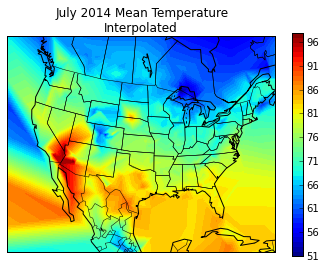

In [14]:
# Interpolate the mean temperature readings in the region of interest

if not skip_plot:
    m = Basemap(llcrnrlon = lon_interest[0], llcrnrlat = lat_interest[0],
                urcrnrlon = lon_interest[1], urcrnrlat = lat_interest[1],
                lon_0 = np.mean(lon_interest), lat_0 = np.mean(lat_interest),
                projection='lcc', resolution='c')
    #m.drawmapboundary(fill_color='aqua')
    #m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    lons = np.array(month_data['Longitude'].values.tolist())
    lats = np.array(month_data['Latitude'].values.tolist())
    values = np.array(month_data['Mean'].values.tolist())
    lons, lats = m(lons, lats)

    # We use integers so that the colorbar labels are integers,
    # which looks nice.
    lower_bound = int(np.floor(month_data_interest['Mean'].values.tolist()).min())
    upper_bound = int(np.ceil(month_data_interest['Mean'].values.tolist()).max())

    m.contourf(lons, lats, values, tri=True,
               levels = np.arange(lower_bound, upper_bound, 1))
    plt.colorbar()
    plt.title(month_names[month] +' 2014 Mean Temperature\n'
              + 'Interpolated')
    plt.show()

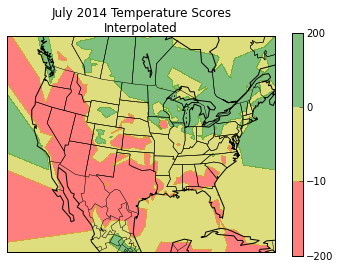

Highs and lows in the green regions are within the
desired temperature range of 50-80 degrees Fahrenheit.

Highs and lows in the yellow regions are
within 10 degrees of the desired temperature range.

Highs and lows the red regions are not
within 10 degrees of the desired temperature range.



In [15]:
# Interpolate the temperature scores in the region of interest.

if not skip_plot:
    m = Basemap(llcrnrlon = lon_interest[0], llcrnrlat = lat_interest[0],
                urcrnrlon = lon_interest[1], urcrnrlat = lat_interest[1],
                lon_0 = np.mean(lon_interest), lat_0 = np.mean(lat_interest),
                projection='lcc', resolution='c')
    #m.drawmapboundary(fill_color='aqua')
    #m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    lons = np.array(month_data['Longitude'].values.tolist())
    lats = np.array(month_data['Latitude'].values.tolist())
    values = np.array(month_data['Temperature Score'].values.tolist())
    lons, lats = m(lons, lats)

    # We use integers so that the colorbar labels are integers,
    # which looks nice.
    lower_bound = int(np.floor(month_data_interest['Temperature Score'].values.tolist()).min())
    upper_bound = int(np.ceil(month_data_interest['Temperature Score'].values.tolist()).max())

    m.contourf(lons, lats, values, tri=True,
               #levels = np.arange(lower_bound, upper_bound, 1))
               levels = [-200,-10,0,200], colors=('r','y','g'), alpha = .5)
    plt.colorbar()
    plt.title(month_names[month] +' 2014 Temperature Scores\n'
              + 'Interpolated')
    plt.show()
    print color_description

    times.append(time.time())
    tasks.append('plot')

In [16]:
# Display the amount of time that each task took.

print 'Runtime:', times[-1] - times[0], 'seconds'
time_deltas = np.array(times)[1:] - np.array(times)[:-1]

df = pd.DataFrame({
                    'Task': tasks[1:],
                    'Time (seconds)': time_deltas})
df

Runtime: 43.7537579536 seconds


,Task,Time (seconds)
0,process station data,0.547429
1,process weather data,30.298601
2,join dataframes,0.497822
3,plot,12.409906
